# Python import

In [114]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from scipy.spatial.distance import cdist
from sympy import Point, Polygon, Line

# Image preprocessing

In [2]:
def apply_transformation(image) :
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    _, otsu_thresholded = cv2.threshold(blurred_image, 165, 255, cv2.THRESH_BINARY)
    edges_image = cv2.Canny(otsu_thresholded, threshold1=50, threshold2=150)
    dilation_kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(edges_image, dilation_kernel, iterations=1)
    lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=200, minLineLength=100, maxLineGap=25)
    hough_image = dilated_image
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_image, (x1, y1), (x2, y2), (255,255,255), 3)

    erosion_kernel = np.ones((3, 3), np.uint8)
    erosed_image = cv2.erode(hough_image, erosion_kernel, iterations=1)
    return erosed_image

In [3]:
def get_red_line(image) :
    lines = cv2.HoughLines(image, rho=1, theta=np.pi/180, threshold=250)
    output_lines = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            output_lines.append([x1,y1,x2,y2])
    return output_lines

In [4]:
def put_red_lines(image, lines) :
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return image

In [5]:
def get_raw_oriented_line(image) : 
    lines = cv2.HoughLines(image, rho=1, theta=np.pi/180, threshold=250)
    horizontal_lines = []
    vertical_lines = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            if np.pi / 2 - 0.1 <= theta <= np.pi / 2 + 0.1:
                horizontal_lines.append((rho, theta))
            elif theta <= 0.1 or theta >= np.pi - 0.1:
                vertical_lines.append((rho, theta))
    return (horizontal_lines, vertical_lines)

In [6]:
def get_oriented_line(image) :
    horizontal_lines, vertical_lines = get_raw_oriented_line(image)
    output_horizontal_lines = []
    output_vertical_ilnes = []
    # Draw horizontal lines
    for rho, theta in horizontal_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        output_horizontal_lines.append([x1,y1,x2,y2])
    # Draw vertical lines
    for rho, theta in vertical_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        output_vertical_ilnes.append([x1,y1,x2,y2])
    return output_horizontal_lines, output_vertical_ilnes


In [7]:
def put_oriented_line(image, horizontal_lines, vertical_lines) :
    for h_line in horizontal_lines:
        x1, y1, x2, y2 = h_line
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for v_line in vertical_lines:
        x1, y1, x2, y2 = v_line
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image


In [8]:
def get_intersection_point(image) : 
    horizontal_lines, vertical_lines = get_raw_oriented_line(image)
    intersection_points = []

    for rho_h, theta_h in horizontal_lines:
        for rho_v, theta_v in vertical_lines:
            a_h = np.cos(theta_h)
            b_h = np.sin(theta_h)
            a_v = np.cos(theta_v)
            b_v = np.sin(theta_v)
            determinant = a_h * b_v - b_h * a_v
            if abs(determinant) > 1e-10: 
                x = (b_v * rho_h - b_h * rho_v) / determinant
                y = (a_h * rho_v - a_v * rho_h) / determinant
                intersection_points.append((int(x), int(y)))
    return intersection_points

In [9]:
def put_intersection_point(image,intersection_points) :
    for x, y in intersection_points:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    return image

In [10]:
def get_corner(image, intersection_points) :
    red_regions = cv2.cvtColor(put_intersection_point(image * 0, intersection_points), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(red_regions, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    threshold = 0.01 * dst.max()
    corners = np.argwhere(dst > threshold)
    height, width = gray.shape
    image_corners = [
        (0, 0),               # Top-left
        (0, height - 1),       # Top-right 0, width - 1
        (width - 1, 0),      # Bottom-left height - 1, 0
        (height - 1, width - 1)  # Bottom-right
    ]
    refined_corners = []
    for corner in image_corners:
        distances = np.linalg.norm(corners - np.array(corner), axis=1)
        closest_idx = np.argmin(distances)
        refined_corners.append([corners[closest_idx][1],corners[closest_idx][0]])
    
    return refined_corners


In [11]:
def apply_crop_image(image, corners) :
    corners = np.float32(corners)
    src_points = corners
    dst_points = np.float32([
        [0, 0],
        [500, 0],
        [0, 500],
        [500, 500]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    output_size = (500, 500) 
    warped_image = cv2.warpPerspective(image, matrix, output_size)
    
    return warped_image

In [ ]:
def apply_sol2(image) :
    transformed_image = apply_transformation(image)
    red_lines = get_red_line(transformed_image)
    horizontal_lines, vertical_lines = get_oriented_line(transformed_image)
    intersection_points = get_intersection_point(transformed_image)
    corners = get_corner(image,intersection_points)
    croped_image = apply_crop_image(image,corners)
    plt.imshow(put_oriented_line(image,horizontal_lines,vertical_lines))

In [108]:
def line_intersection(_line1, _line2):
    line1 = (_line1[0:2],_line1[2:4])
    line2 = (_line2[0:2],_line2[2:4])
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return -1, -1

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def filter_separate_lines(lines):
    separate_lines = []
    for i, line1 in enumerate(lines):
        is_separate_from_all = True
        for j, line2 in enumerate(separate_lines):
            x,y = line_intersection(line1,line2)
            if x >= 0 and x <= 1000 and y >= 0 and y <= 1000:
                is_separate_from_all = False
                break
        if is_separate_from_all:
            separate_lines.append(line1)
    return separate_lines

In [136]:
def get_intersect_board_line(lines,corners) :
    output_lines = []
    for line in lines :
        board_poly = Polygon(corners[0], corners[1], corners[3], corners[2])
        if board_poly.intersection(Line(Point(line[0],line[1]), Point(line[2], line[3]))) :
            output_lines.append(line)
    return output_lines

In [ ]:
def get_shrink_corners(corners, x) :
    corners[0][0] += x
    corners[0][1] += x
    corners[1][0] -= x
    corners[1][1] += x
    corners[2][0] -= x
    corners[2][1] -= x
    corners[3][0] += x
    corners[3][1] -= x
    return corners

In [ ]:
def get_cell_cordinate(image, corners = None, horizontal_lines = None, vertical_lines = None) :
    if corners == None :
        transformed_image = apply_transformation(image)
        intersection_points = get_intersection_point(transformed_image)
        corners = get_corner(image,intersection_points)
    shrink_corners = get_shrink_corners([corners[0],corners[1],corners[3],corners[2]], 10)
    board_mask = cv2.fillPoly(image * 0,[np.array(shrink_corners)],(255,255,255))
    mask_image = cv2.bitwise_and(image,board_mask)
    if(horizontal_lines == None or vertical_lines == None) :
        transformed_image = apply_transformation(image)
        horizontal_lines, vertical_lines = get_oriented_line(transformed_image)
    horizontal_lines_separate = filter_separate_lines(horizontal_lines)
    vertical_lines_separate = filter_separate_lines(vertical_lines)
    horizontal_lines_intersect = get_intersect_board_line(horizontal_lines_separate, shrink_corners)
    vertical_lines_intersect = get_intersect_board_line(vertical_lines_separate, shrink_corners)

    return horizontal_lines_intersect, vertical_lines_intersect

In [ ]:
def is_left()

In [ ]:
def put_piece(board, data, horizontal_lines_intersect, vertical_lines_intersect) :


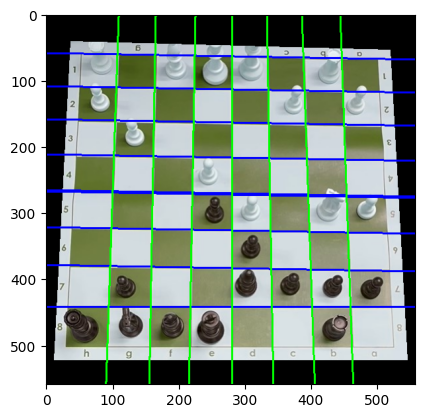

In [138]:
image_path = 'image.jpg'
image = cv2.imread(image_path)
get_cell_cordinate(image)

# Chess piece detection

In [ ]:
MODEL_FOLDER = "yolov5/"
VIDEO_FOLDER = "yolov5/test-video/"
OUTPUT_FOLDER = ""

MODEL_FILE = "chess-v2.pt"
VIDEO_FILE = "2_move_student.mp4"
OUTPUT_FILE = "detectAlgoOutput.avi"

In [ ]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1, yi1 = max(x1, x1_), max(y1, y1_)
    xi2, yi2 = min(x2, x2_), min(y2, y2_)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area

In [ ]:
def non_max_suppression_custom(detections, iou_threshold=0.6):
    filtered_boxes = []
    while len(detections) > 0:
        detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
        best_box = detections.pop(0) 
        filtered_boxes.append(best_box)

        detections = [
            box for box in detections
            if calculate_iou(
                (best_box['xmin'], best_box['ymin'], best_box['xmax'], best_box['ymax']),
                (box['xmin'], box['ymin'], box['xmax'], box['ymax'])
            ) < iou_threshold
        ]
    return filtered_boxes

In [ ]:
def load_model() :
    # device = torch.device('cuda')
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_FOLDER + MODEL_FILE)
    model.conf = 0.2
    model.iou = 0.9
    # model.to(device)
    return model

In [ ]:
def get_frame_predict(frame, model) :
    # model.to()
    results = model(frame)
    detections = results.pandas().xyxy[0]
    detections_list = [
        {
            'xmin': int(row['xmin']),
            'ymin': int(row['ymin']),
            'xmax': int(row['xmax']),
            'ymax': int(row['ymax']),
            'confidence': float(row['confidence']),
            'name': row['name']
        }
        for _, row in detections.iterrows()
    ]
    filtered_detections = non_max_suppression_custom(detections_list, iou_threshold=0.6)
    return filtered_detections

In [ ]:
model = load_model()

video_path = VIDEO_FOLDER + VIDEO_FILE
output_path = OUTPUT_FOLDER + OUTPUT_FILE

cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, 1, (width, height))

frame_count = 0
processed_frame = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % fps == 0:
        filtered_detections = get_frame_predict(frame, model)

        print(f"Filtered detections for frame {frame_count}:")
        for detection in filtered_detections:
            print(detection)

        for det in filtered_detections:
            xmin, ymin, xmax, ymax = det['xmin'], det['ymin'], det['xmax'], det['ymax']
            label = f"{det['name']} {det['confidence']:.2f}"
            color = (0, 255, 0) if det['name'] == "chessboard" else (0, 0, 255)  # Green for chessboard, Red for pieces
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        out.write(frame)

        cv2.imshow('YOLOv5 Chess Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video with detections (1 FPS) saved to {output_path}")